In [1]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

Matplotlib is building the font cache; this may take a moment.
/Users/igorsergio/Documents/UFRN/2025.2/MLOPS/U3/EAD_2_trabalhoFinal/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/igorsergio/Documents/UFRN/2025.2/MLOPS/U3/EAD_2_trabalhoFinal/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Architecture class

In [2]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor * iteration)
    return lr_fn

class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.scheduler = None
        self.is_batch_lr_scheduler = False
        self.is_reduce_lr_on_plateau = False

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_lr_scheduler(self, scheduler):
        # Makes sure the scheduler is assigned to an attribute
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
                isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                self.is_reduce_lr_on_plateau = True
            else:
                self.is_reduce_lr_on_plateau = False

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if not validation and self.is_batch_lr_scheduler:
                self.scheduler.step()

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If the scheduler is not a batch scheduler, we step it here
            if self.scheduler and not self.is_batch_lr_scheduler:
                if self.is_reduce_lr_on_plateau:
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

## Data generation

In [3]:
def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 10 + ((n_plot % 10) > 0)
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows))
    axes = np.atleast_2d(axes)

    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 10, i % 10
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%

100.0%

100.0%

100.0%



In [5]:
print(f"Tamanho do treino: {len(train_data)}")
print(f"Classes únicas: {torch.unique(train_data.targets)}")

print(f"Tamanho do treino: {len(test_data)}")
print(f"Classes únicas: {torch.unique(test_data.targets)}")

Tamanho do treino: 60000
Classes únicas: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Tamanho do treino: 10000
Classes únicas: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [6]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

**Classes do dataset**

0 T-shirt / Top

1 Calças

2 Camisola

3 Vestido

4 Casaco

5 Sandália

6 Camisa

7 Sapatilha / Ténis

8 Mala / Bolsa

9 Bota

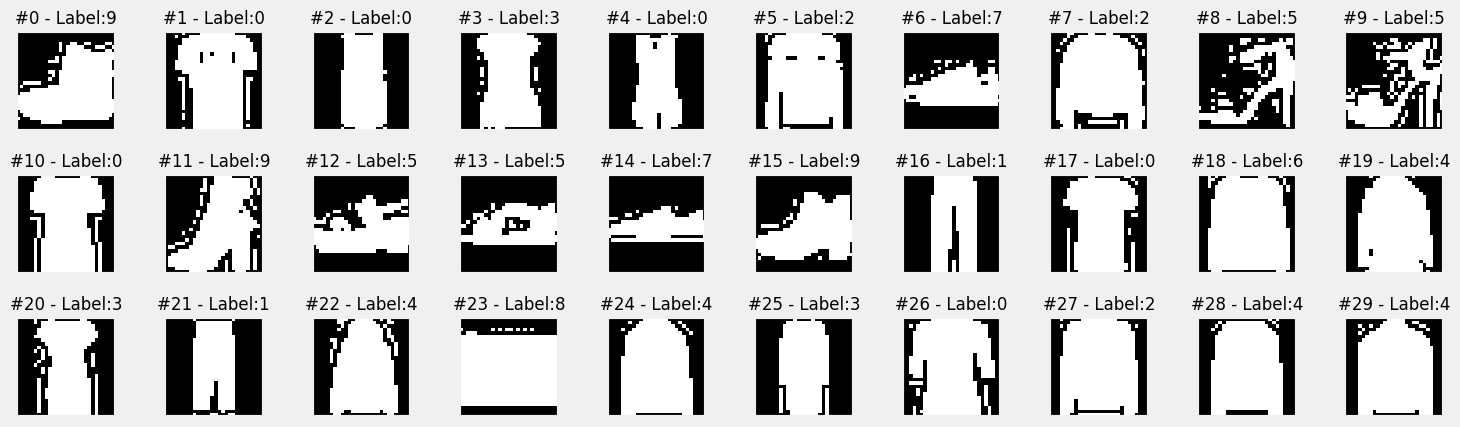

In [9]:
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

fig = plot_images(train_images, train_labels)

In [10]:
train_images.shape

(60000, 28, 28)

In [11]:
train_labels.shape

(60000,)

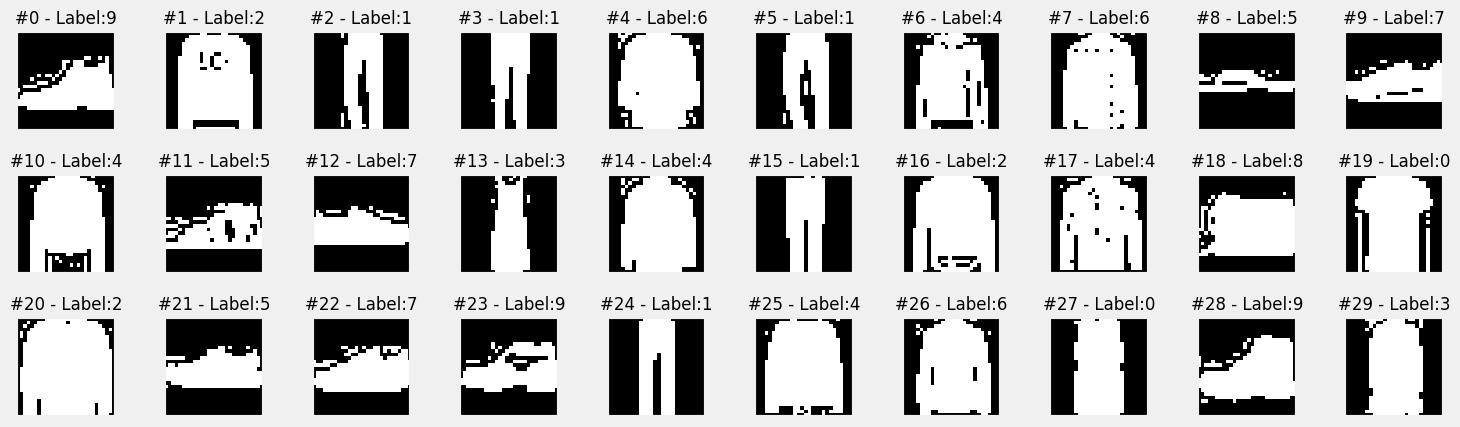

In [12]:
test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

fig = plot_images(test_images, test_labels, n_plot=30)

In [13]:
test_images.shape

(10000, 28, 28)

In [14]:
test_labels.shape

(10000,)

## Data Preparation

In [15]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [16]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [17]:
# Balance the classes in the training dataset
sampler = make_balanced_sampler(train_data.targets)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_data, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=test_data, batch_size=16)


## Model

### Configuration

In [18]:
torch.manual_seed(42)
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('relu1', nn.ReLU())
lenet.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('relu2', nn.ReLU())
lenet.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('relu3', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet.add_module('relu4', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

### Training

In [ ]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(lenet.parameters(), lr=lr)

In [ ]:
arch_cnn1 = Architecture(lenet, multi_loss_fn, optimizer_cnn1)
arch_cnn1.set_loaders(train_loader, val_loader)

In [ ]:
arch_cnn1.train(15)

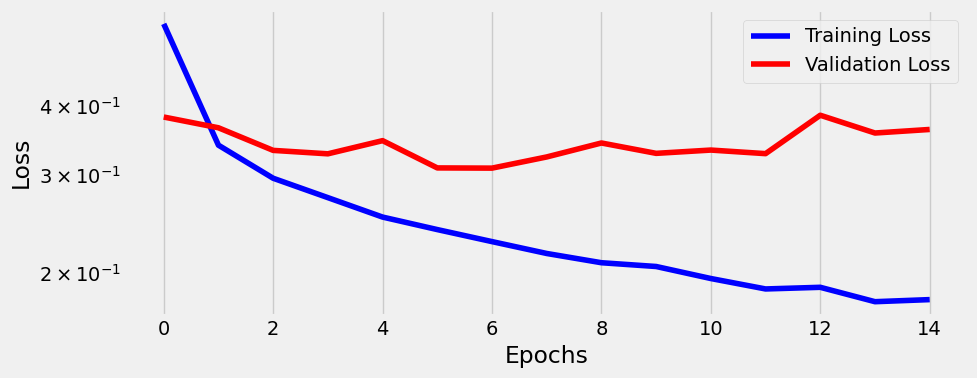

In [ ]:
fig = arch_cnn1.plot_losses()

### Visualizing Filters

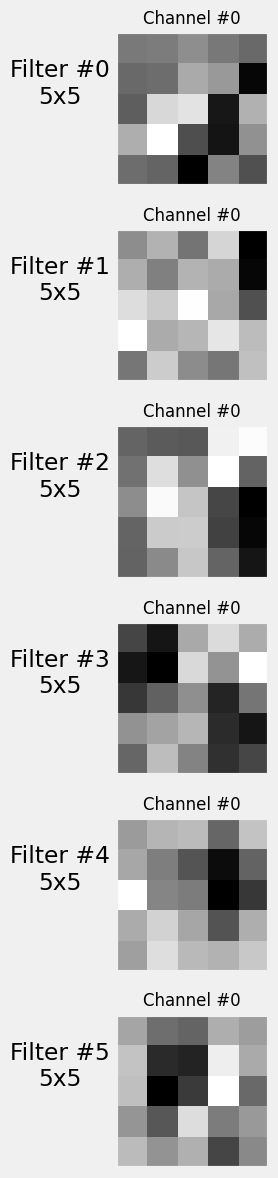

In [ ]:
fig_filters = arch_cnn1.visualize_filters('conv1', cmap='gray')

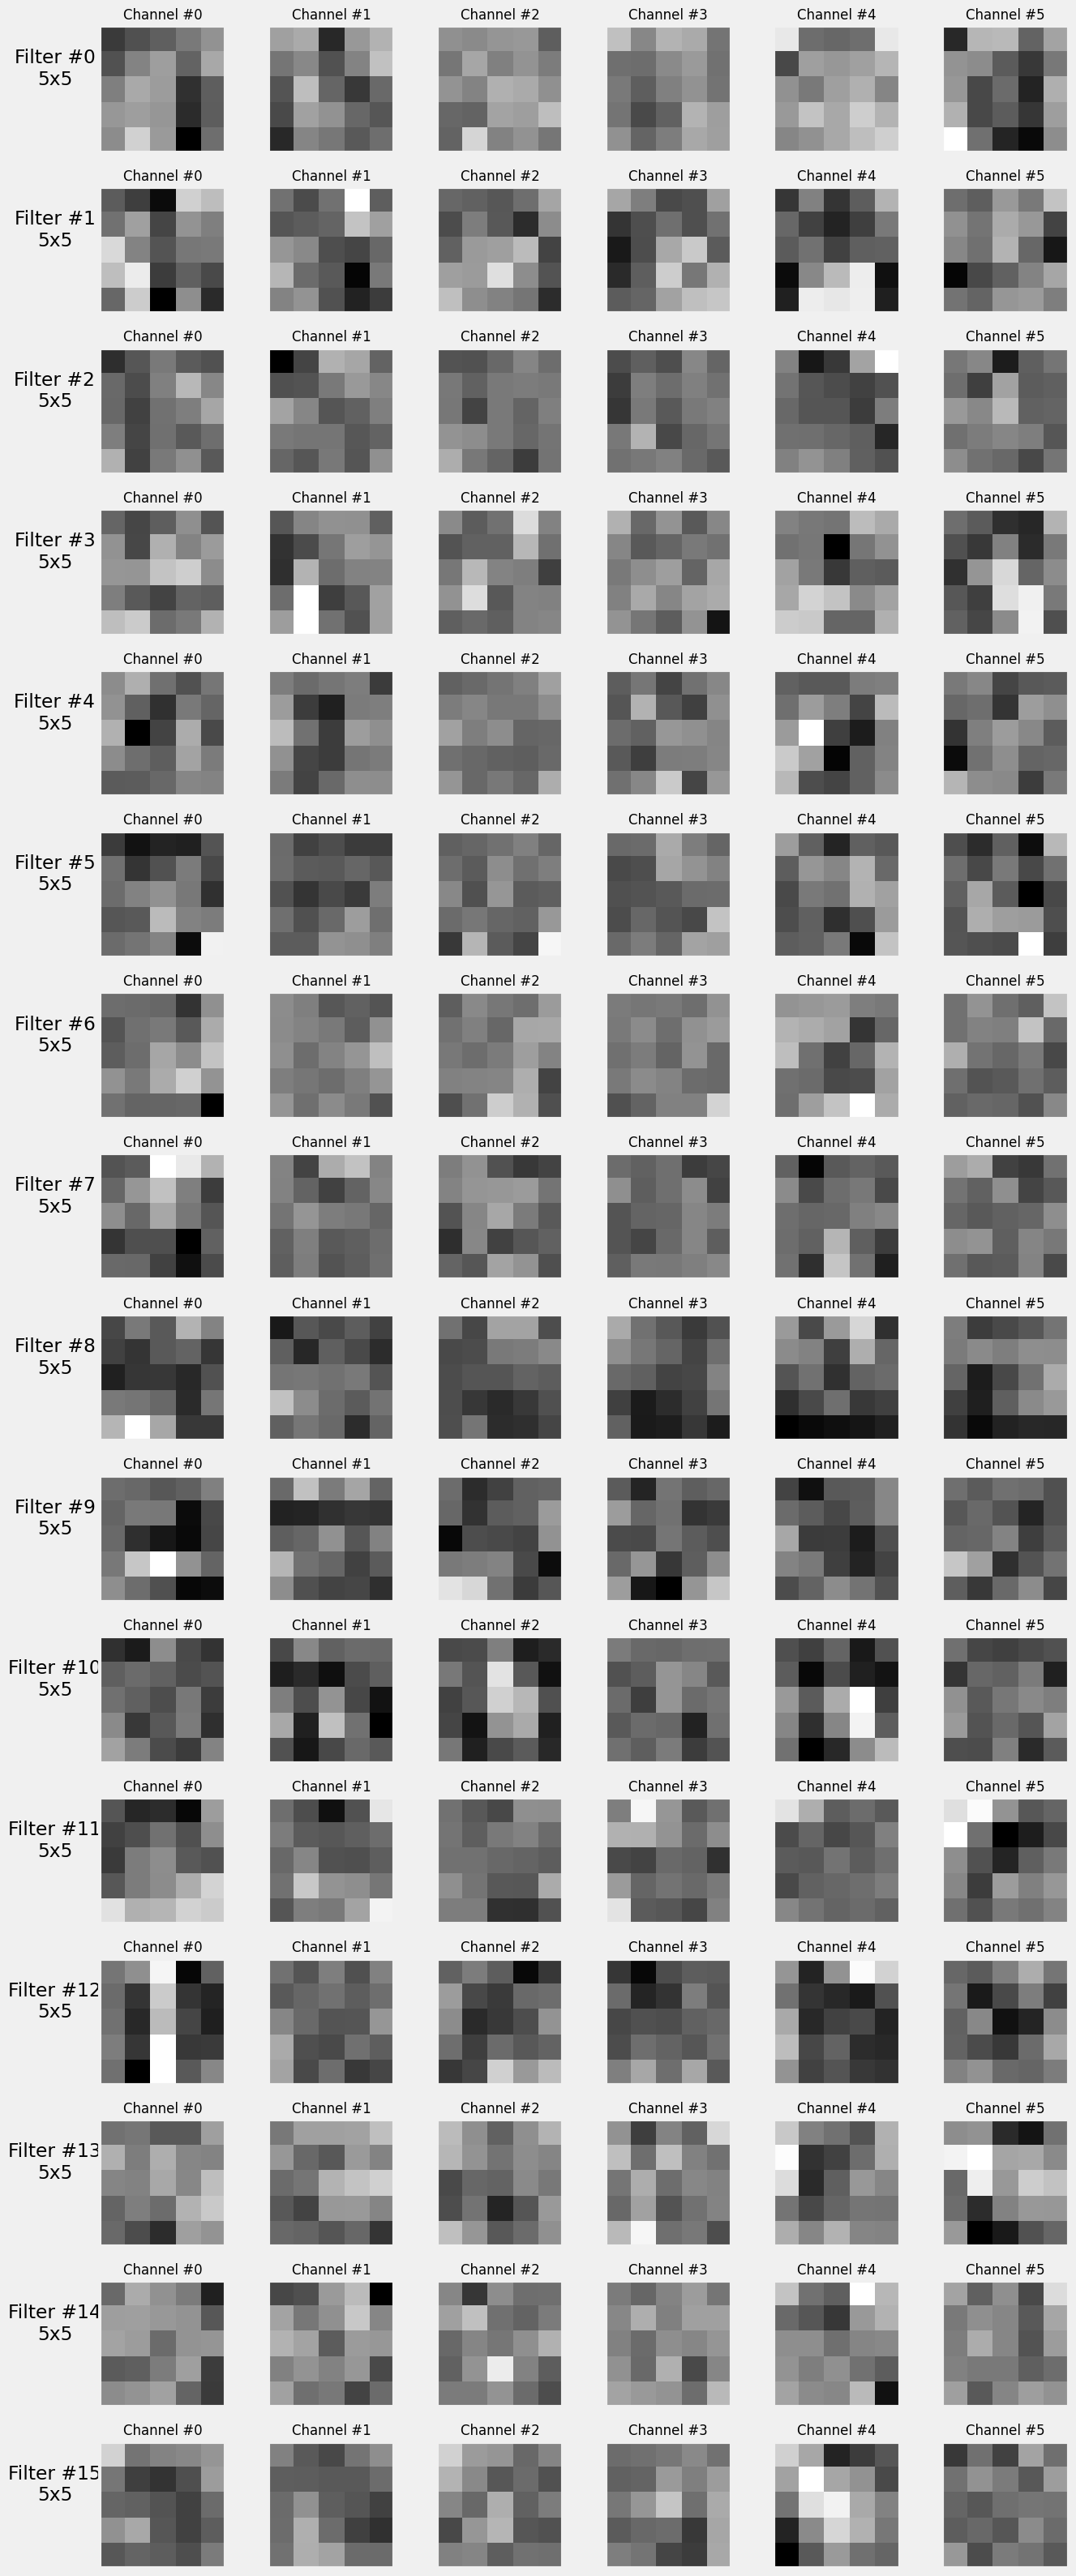

In [ ]:
fig_filters = arch_cnn1.visualize_filters('conv2', cmap='gray')

## Capturing Outputs

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1','conv2', 'relu2', 'maxp2', 'flatten']
classifier_layers = ['fc1', 'relu4', 'OUTPUT']

arch_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = arch_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

arch_cnn1.remove_hooks()

### Visualizing Feature Maps

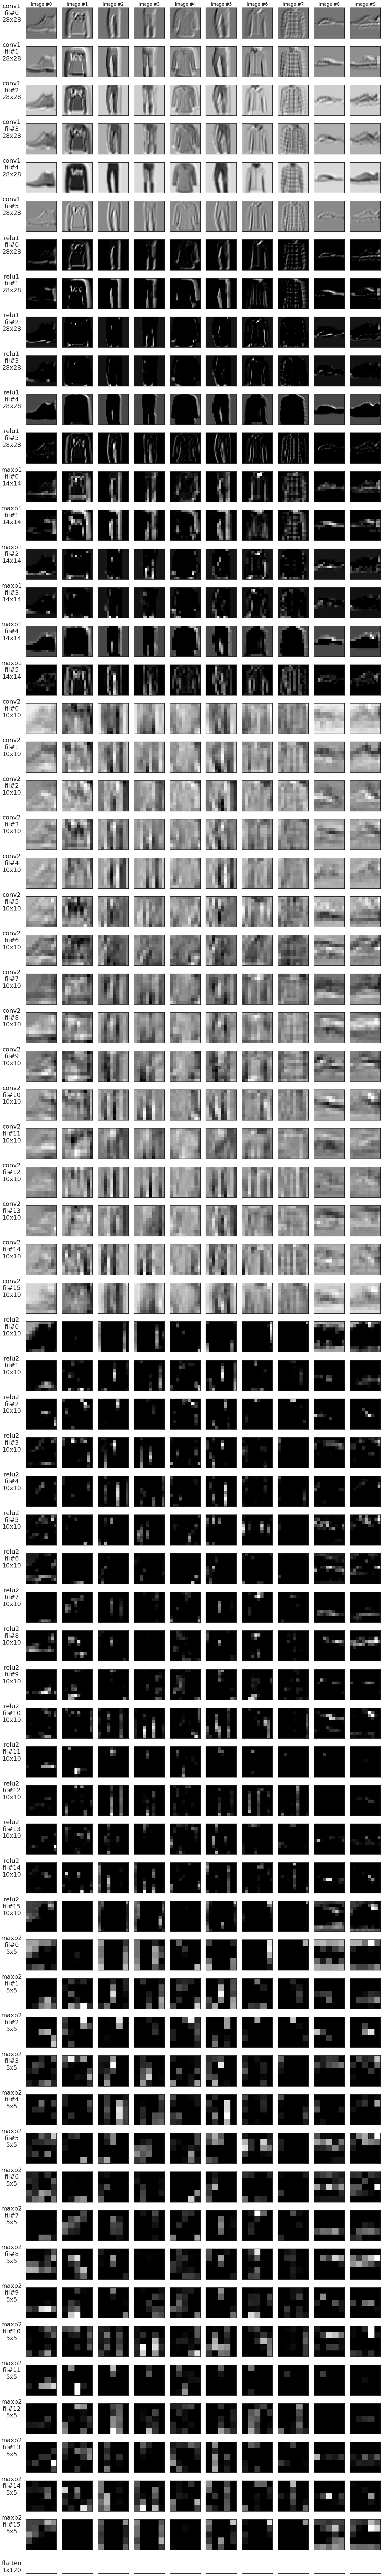

In [ ]:
with plt.style.context('seaborn-v0_8-white'):
    fig_maps1 = arch_cnn1.visualize_outputs(featurizer_layers)

### Visualizing Classifier Layers


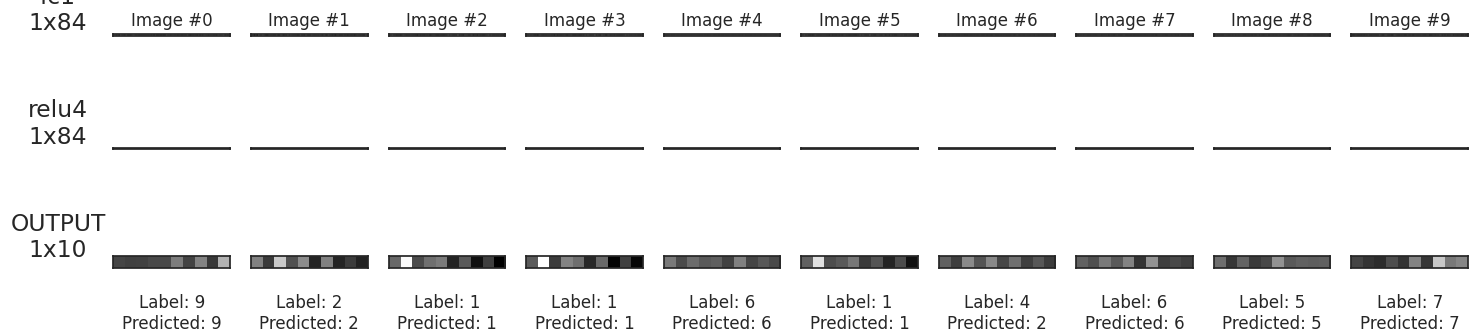

In [ ]:
with plt.style.context('seaborn-v0_8-white'):
    fig = arch_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

### Accucary

In [ ]:
print(f"Latest Training Loss: {arch_cnn1.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_cnn1.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_cnn1.train_loader, arch_cnn1.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_cnn1.val_loader, arch_cnn1.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Latest Training Loss: 0.1787
Latest Validation Loss: 0.3623
Training Accuracy: 92.64%
Validation Accuracy: 88.69%


In [ ]:
arch_cnn1.correct(images_batch,
                  labels_batch)

tensor([[0, 0],
        [4, 4],
        [1, 1],
        [1, 1],
        [2, 3],
        [2, 2],
        [2, 2],
        [2, 2],
        [0, 0],
        [1, 1]])

In [ ]:
Architecture.loader_apply(arch_cnn1.val_loader,
                          arch_cnn1.correct)

tensor([[ 881, 1000],
        [ 972, 1000],
        [ 849, 1000],
        [ 916, 1000],
        [ 810, 1000],
        [ 929, 1000],
        [ 605, 1000],
        [ 957, 1000],
        [ 969, 1000],
        [ 981, 1000]])

## EWMA Meets Gradients

### EWMA Meets Gradients (Médias Móveis Exponencialmente Ponderadas)

Ao treinar redes neurais com Gradient Descent e mini-batches, os gradientes oscilam violentamente. A EWMA (Exponentially Weighted Moving Average) atua como um filtro passa-baixa essencial para estabilizar o aprendizado.

1. Suavização e Estabilidade

Suavizar variações: A EWMA reduz o ruído inerente aos mini-batches, revelando a tendência real da descida do gradiente.Estabilidade: Permite atualizações de pesos mais consistentes, evitando ziguezagues desnecessários na otimização.

2. A Matemática e Janelas

EquivalentesA fórmula recursiva é $V_t = \beta V_{t-1} + (1-\beta)\theta_t$.A "janela equivalente" ($N$) de uma média móvel simples que corresponderia ao decaimento da EWMA é aproximada por:$$N \approx \frac{1}{1-\beta} \implies \alpha \approx \frac{2}{N+1}$$

3. Otimizadores Adaptativos

Esta técnica é o "motor" de otimizadores como Adam e RMSProp, que usam EWMA (com correção de viés) para estimar a média e a variância dos gradientes, adaptando a taxa de aprendizado para cada parâmetro individualmente.

In [ ]:
# Calcula Média Móvel Simples (MA)
def moving_average(data, N):
    return [sum(data[i:i+N])/N for i in range(len(data)-N+1)]

# Cálculo EWMA
def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

# Calcula a série EWMA para uma lista de valores dado um período equivalente
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

# Correção de Viés (Bias Correction) usada no Adam
def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

# Correção de Viés (Bias Correction) usada no Adam
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

In [ ]:
from copy import deepcopy

# Configuração do Modelo e Otimizador
torch.manual_seed(42)

optimizer_viz = optim.SGD(lenet.parameters(), lr=0.01)
loss_fn_viz = nn.CrossEntropyLoss(reduction='mean')

arch_viz = Architecture(lenet, loss_fn_viz, optimizer_viz)
arch_viz.set_loaders(train_loader, val_loader)

grads_history = []

def log_gradient_hook(grad):
    # Captura o gradiente do primeiro peso (índice 0,0,0,0) e converte para escalar
    grads_history.append(grad[0, 0, 0, 0].item())

# Registra o hook no tensor de pesos da camada conv1
handle = arch_viz.model.conv1.weight.register_hook(log_gradient_hook)

# Treina por 1 época
arch_viz.train(1)

# Remover o hook para limpar a memória
handle.remove()

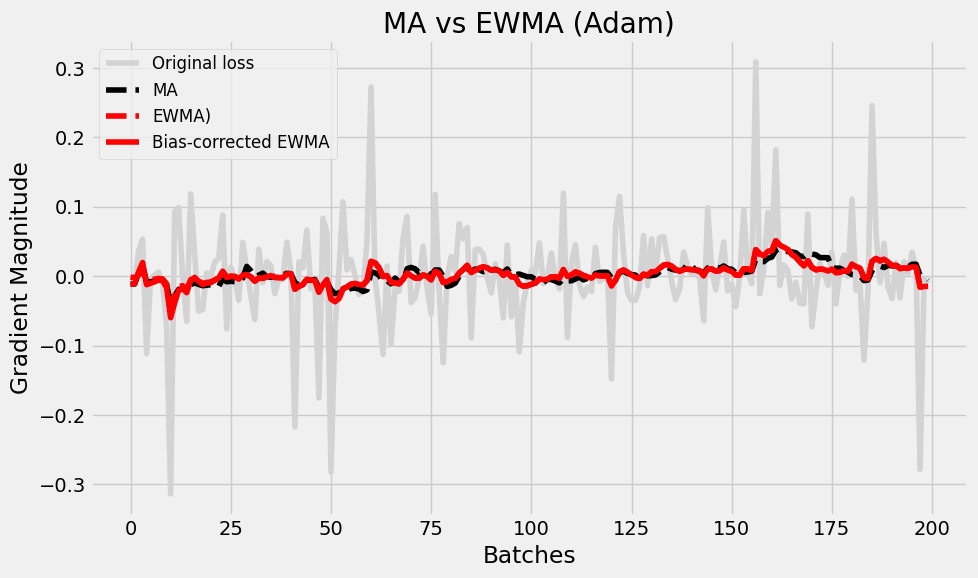

In [ ]:
def ma_vs_ewma(values, periods=19):
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(values, c='lightgray', label='Original loss')
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA)')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='Bias-corrected EWMA')
    ax.set_title('MA vs EWMA (Adam)')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_xlabel('Batches')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

raw_gradients = np.array(grads_history)

# Período equivalente (Beta=0.9 no Adam ~= 19 passos)
period_adam = 19

fig = ma_vs_ewma(raw_gradients[:200], periods=period_adam)
plt.show()

## Adam

### Momentum + Escalonamento Adaptativo

Nesta seção, exploramos o Adam (Adaptive Moment Estimation), que combina as melhores propriedades de dois outros otimizadores:

Momentum (via SGD): Usa uma média móvel dos gradientes (1º momento) para suavizar a descida e manter a direção.

RMSProp (Escalonamento): Usa uma média móvel dos gradientes ao quadrado (2º momento) para normalizar a atualização, adaptando o Learning Rate para cada parâmetro individualmente.

### A Matemática do Adam

A atualização de um parâmetro $\theta$ no passo $t$ é dada por:
$$\theta_t = \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Onde:

$\eta$: Learning Rate (passo global).

$\hat{m}_t$: EWMA dos Gradientes (com correção de viés). Suaviza o ruído.

$\hat{v}_t$: EWMA dos Gradientes ao Quadrado (com correção de viés). Estima a variância/magnitude.

O Papel dos Hiperparâmetros

$\beta_1$ (Beta 1): Controla o decaimento do Momentum ($m_t$). Padrão: 0.9 (janela curta, ~19 passos).

$\beta_2$ (Beta 2): Controla o decaimento do Escalonamento ($v_t$). Padrão: 0.999 (janela longa, ~1999 passos).

$\epsilon$ (Epsilon): Um valor muito pequeno (ex: 1e-8) para evitar divisão por zero e garantir estabilidade numérica.

In [ ]:
torch.manual_seed(42)
lenet_adam = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_adam.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_adam.add_module('relu1', nn.ReLU())
lenet_adam.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_adam.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_adam.add_module('relu2', nn.ReLU())
lenet_adam.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_adam.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_adam.add_module('relu3', nn.ReLU())
# Flattening
lenet_adam.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_adam.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_adam.add_module('relu4', nn.ReLU())
# Output Layer
lenet_adam.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

In [ ]:
# Configuração dos Otimizadores

opt_adam = optim.Adam(lenet_adam.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

arch_adam = Architecture(lenet_adam, loss_fn, opt_adam)
arch_adam.set_loaders(train_loader, val_loader)

# Configuração do Hook
adam_grads_history = []

def log_adam_grad(grad):
    adam_grads_history.append(grad[0, 0, 0, 0].item()) # Captura conv1

# Registra o hook no modelo do Adam
hook_handle = arch_adam.model.conv1.weight.register_hook(log_adam_grad)

arch_adam.train(15)

hook_handle.remove()

In [ ]:
def figure11(losses_sgd, val_losses_sgd, losses_adam, val_losses_adam):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses_sgd, 'b', label='Training Losses - SGD')
    axs.plot(val_losses_sgd, 'r', label='Validation Losses - SGD')
    axs.plot(losses_adam, 'b--', label='Training Losses - Adam')
    axs.plot(val_losses_adam, 'r--', label='Validation Losses - Adam')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('SGD x Adam')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

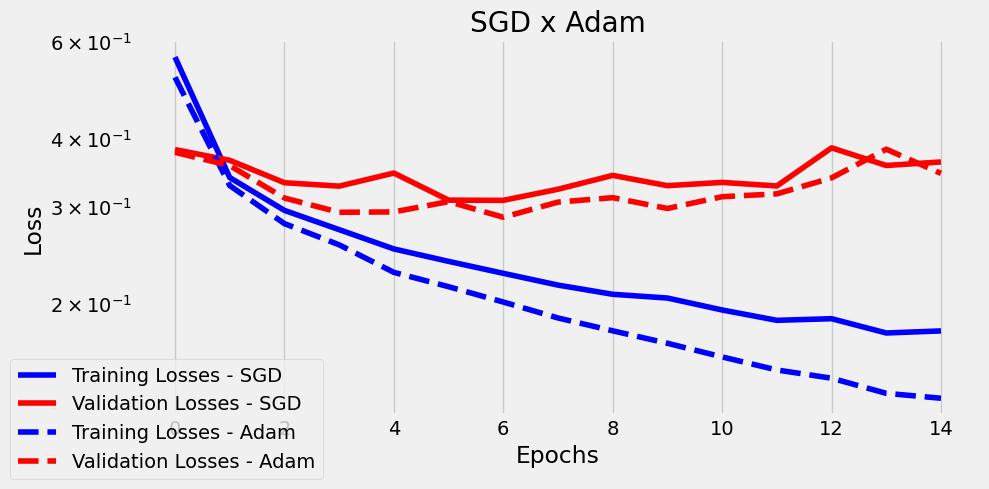

In [ ]:
fig = figure11(arch_cnn1.losses, arch_cnn1.val_losses, arch_adam.losses, arch_adam.val_losses)

In [ ]:
print(f"Latest Training Loss: {arch_adam.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_adam.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_adam.train_loader, arch_adam.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_adam.val_loader, arch_adam.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Latest Training Loss: 0.1348
Latest Validation Loss: 0.3453
Training Accuracy: 94.95%
Validation Accuracy: 90.28%


gradiente

## Visualizing Adapted Gradients

Para entender profundamente como o Adam estabiliza o treinamento, precisamos visualizar as três etapas que transformam um gradiente cru em um gradiente adaptado:

Suavização (Smoothing): O gradiente cru ($g_t$) é ruidoso. O Adam aplica uma EWMA ($\beta_1$) para obter um gradiente suavizado ($m_t$). Isso é equivalente ao Momentum.

Escalonamento (Scaling): O Adam estima a variância dos gradientes calculando a EWMA dos quadrados ($\sqrt{v_t}$). Isso serve como um fator de escala: gradientes grandes são reduzidos, gradientes pequenos são amplificados.

Adaptação: O passo final combina os dois. O gradiente adaptado é a direção suavizada dividida pela escala: $\hat{g}_t = \frac{m_t}{\sqrt{v_t} + \epsilon}$.

In [ ]:
#  Dados Crus
raw_gradients = np.array(adam_grads_history)

# Parâmetros do Adam
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Cálculo das EWMAs
m_t = calc_corrected_ewma(raw_gradients, beta1)

# Variância (Escala/Magnitude)
v_t = calc_corrected_ewma(np.power(raw_gradients, 2), beta2)

# 4. Gradiente Adaptado Final
adapted_gradients = m_t / (np.sqrt(np.abs(v_t)) + epsilon)

print("Cálculos concluídos. Shapes:", m_t.shape, v_t.shape, adapted_gradients.shape)

Cálculos concluídos. Shapes: (56250,) (56250,) (56250,)


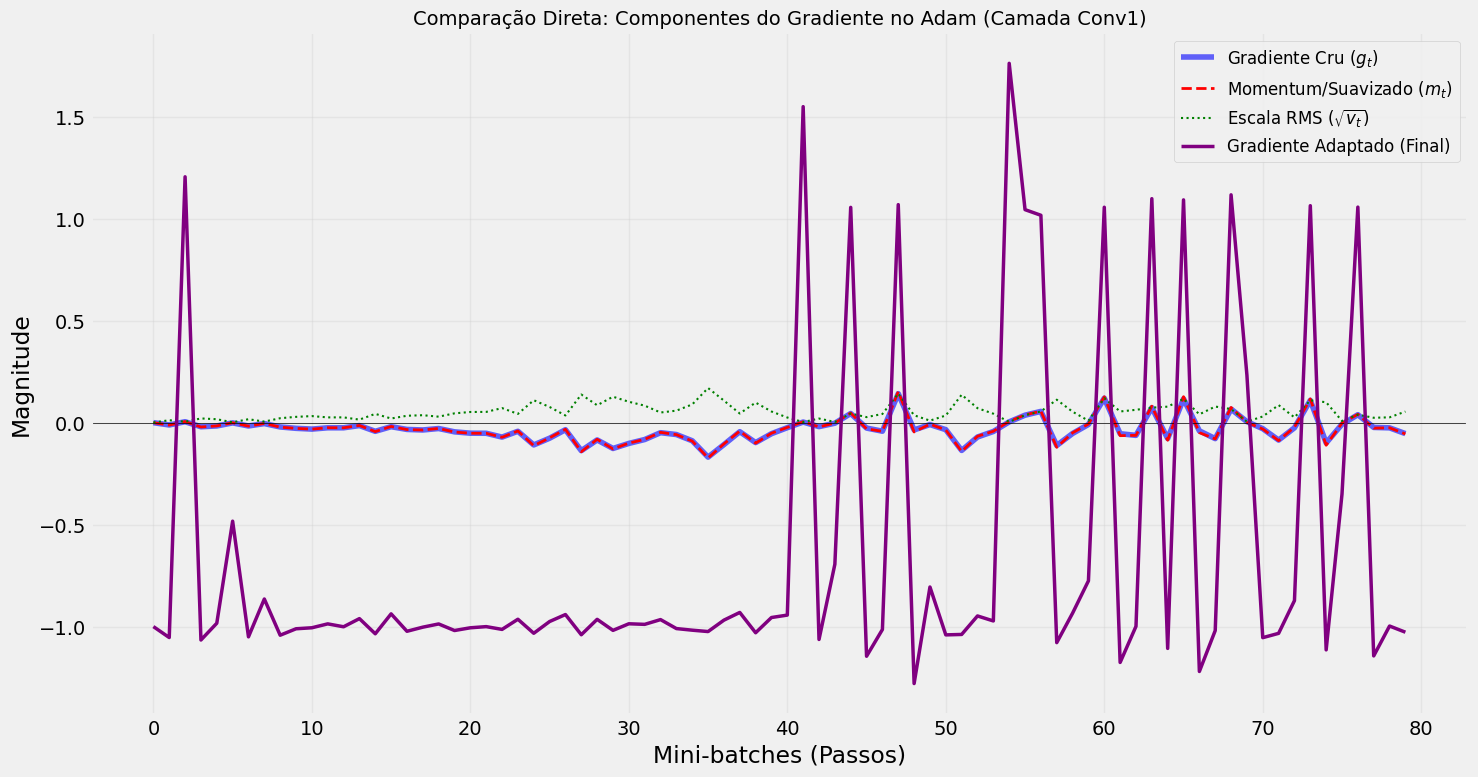

In [ ]:

plt.figure(figsize=(15, 8))

# Limite de passos para melhor visualização
limit = 80
steps = np.arange(len(raw_gradients))[:limit]

# 2. Plotagem das Curvas
# Gradiente Cru (azul)
plt.plot(steps, raw_gradients[:limit], color='b', alpha=0.6, label='Gradiente Cru ($g_t$)', zorder=1)

# Momentum (Vermelho)
plt.plot(steps, m_t[:limit], color='red', linewidth=2, linestyle='--', label='Momentum/Suavizado ($m_t$)', zorder=2)

# Escala RMS (Verde)
plt.plot(steps, np.sqrt(np.abs(v_t[:limit])), color='green', linewidth=1.5, linestyle=':', label=r'Escala RMS ($\sqrt{v_t}$)', zorder=3)

# Gradiente Adaptado (Roxo)
plt.plot(steps, adapted_gradients[:limit], color='purple', linewidth=2.5, label='Gradiente Adaptado (Final)', zorder=4)

plt.title('Comparação Direta: Componentes do Gradiente no Adam (Camada Conv1)', fontsize=14)
plt.xlabel('Mini-batches (Passos)')
plt.ylabel('Magnitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='-') # Linha zero para referência
plt.legend(loc='best', fontsize=12, framealpha=0.9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SGD e Suas Variantes

### SGD e Suas Variantes: Acelerando a Convergência

Nesta seção, exploramos como o Gradiente Descendente Estocástico (SGD) evoluiu para lidar com superfícies de perda complexas.

1. SGD Simples

O SGD (Stochastic Gradient Descent) atualiza os pesos usando apenas o gradiente do mini-batch atual.Problema: Ele é "míope". Se o gradiente atual for ruidoso ou apontar para uma direção errada (como em vales estreitos), o SGD oscila muito e converge devagar.
Fórmula: $\theta_t = \theta_{t-1} - \eta \cdot \nabla J(\theta)$

2. SGD com Momentum

O Momentum adiciona "inércia" ao otimizador. Ele acumula uma média móvel dos gradientes passados ($v_t$).

Vantagem: Se os gradientes apontam consistentemente para a mesma direção, o Momentum ganha velocidade (acelera). Se a direção muda (ruído), a inércia mantém o curso, reduzindo oscilações.

Intuição: Uma bola descendo uma ladeira ganha velocidade e não para imediatamente ao encontrar um pequeno buraco.Fórmula:$$v_t = \gamma v_{t-1} + \nabla J(\theta)$$$$\theta_t = \theta_{t-1} - \eta \cdot v_t$$

3. SGD com Nesterov (NAG)

O Nesterov Accelerated Gradient é uma versão mais inteligente do Momentum.

Diferença: Em vez de calcular o gradiente na posição atual ($\theta_{t-1}$), ele "olha à frente". Ele dá um passo na direção do momentum antes de calcular o gradiente.

Vantagem: Se o momentum estiver prestes a levar o otimizador para longe do mínimo (overshoot), o gradiente "futuro" pode corrigir a rota antecipadamente, melhorando a estabilidade.

In [ ]:
torch.manual_seed(42)
lenet_momentum = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_momentum.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_momentum.add_module('relu1', nn.ReLU())
lenet_momentum.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_momentum.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_momentum.add_module('relu2', nn.ReLU())
lenet_momentum.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_momentum.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_momentum.add_module('relu3', nn.ReLU())
# Flattening
lenet_momentum.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_momentum.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_momentum.add_module('relu4', nn.ReLU())
# Output Layer
lenet_momentum.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

In [ ]:
torch.manual_seed(42)
lenet_nesterov = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_nesterov.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_nesterov.add_module('relu1', nn.ReLU())
lenet_nesterov.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_nesterov.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_nesterov.add_module('relu2', nn.ReLU())
lenet_nesterov.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_nesterov.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_nesterov.add_module('relu3', nn.ReLU())
# Flattening
lenet_nesterov.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_nesterov.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_nesterov.add_module('relu4', nn.ReLU())
# Output Layer
lenet_nesterov.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

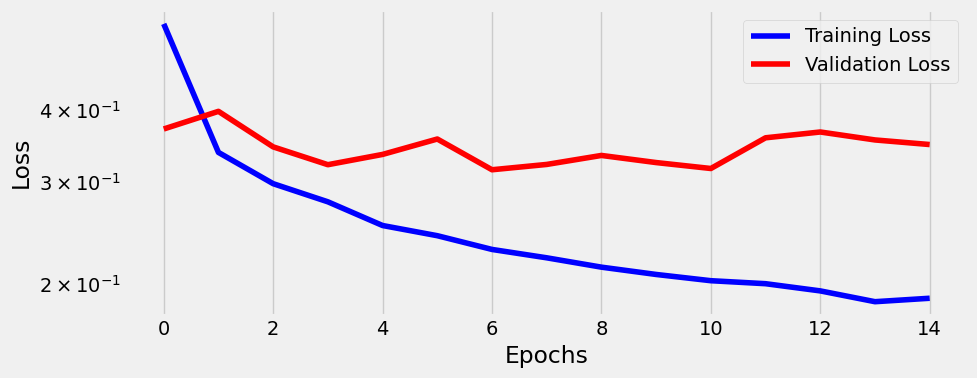

In [ ]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.SGD(lenet_momentum.parameters(), lr= 0.01, momentum= 0.9)

arch_cnn2 = Architecture(lenet_momentum, multi_loss_fn, optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)

arch_cnn2.train(15)

fig = arch_cnn2.plot_losses()

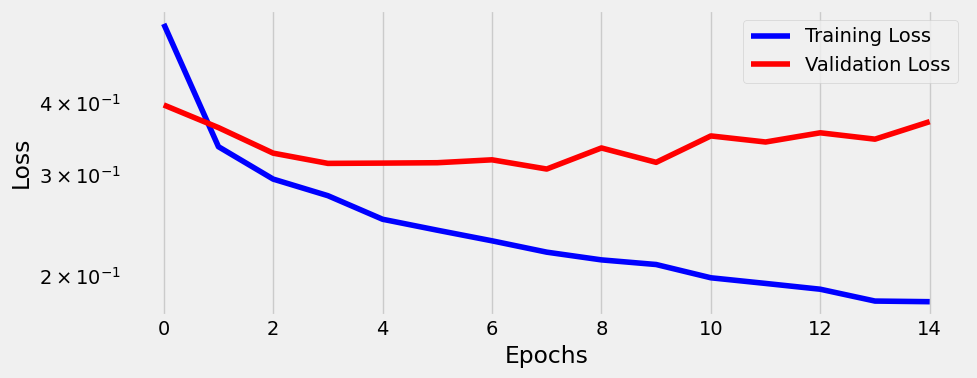

In [ ]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(lenet_nesterov.parameters(), lr= 0.01, momentum= 0.9, nesterov= True)

arch_cnn3 = Architecture(lenet_nesterov, multi_loss_fn, optimizer_cnn3)
arch_cnn3.set_loaders(train_loader, val_loader)

arch_cnn3.train(15)

fig = arch_cnn3.plot_losses()

In [ ]:
def figure12(losses_sgd, val_losses_sgd, losses_adam, val_losses_adam):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses_sgd, 'b', label='Training Losses - SGD')
    axs.plot(val_losses_sgd, 'r', label='Validation Losses - SGD')
    axs.plot(losses_adam, 'b--', label='Training Losses - SGD(momentum)')
    axs.plot(val_losses_adam, 'r--', label='Validation Losses - SGD(momentum)')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('SGD x SGD(momentum)')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

def figure13(losses_sgd, val_losses_sgd, losses_adam, val_losses_adam):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses_sgd, 'b', label='Training Losses - SGD')
    axs.plot(val_losses_sgd, 'r', label='Validation Losses - SGD')
    axs.plot(losses_adam, 'b--', label='Training Losses - SGD(nesterov)')
    axs.plot(val_losses_adam, 'r--', label='Validation Losses - SGD(nesterov)')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('SGD x SGD(nesterov)')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

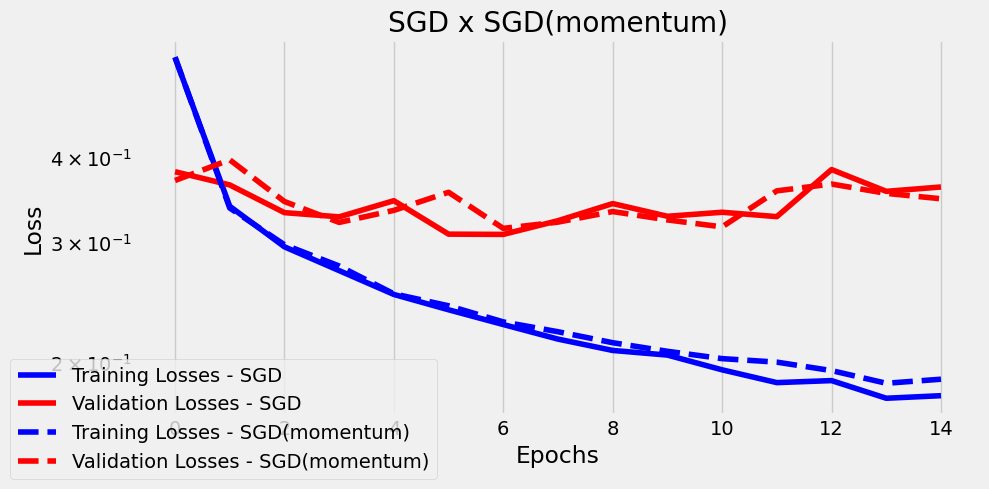

In [ ]:
fig = figure12(arch_cnn1.losses, arch_cnn1.val_losses, arch_cnn2.losses, arch_cnn2.val_losses)

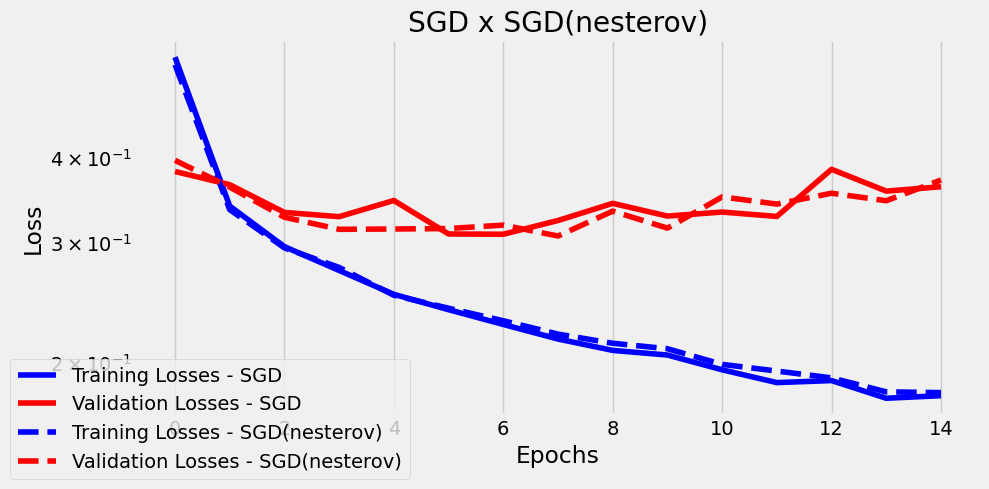

In [ ]:
fig = figure13(arch_cnn1.losses, arch_cnn1.val_losses, arch_cnn3.losses, arch_cnn3.val_losses)

In [ ]:
print(f"Latest Training Loss: {arch_cnn2.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_cnn2.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_cnn2.train_loader, arch_cnn2.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_cnn2.val_loader, arch_cnn2.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Latest Training Loss: 0.1889
Latest Validation Loss: 0.3481
Training Accuracy: 93.16%
Validation Accuracy: 89.16%


In [ ]:
print(f"Latest Training Loss: {arch_cnn3.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_cnn3.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_cnn3.train_loader, arch_cnn3.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_cnn3.val_loader, arch_cnn3.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Latest Training Loss: 0.1805
Latest Validation Loss: 0.3706
Training Accuracy: 91.53%
Validation Accuracy: 88.03%


## Learning Rate Schedulers

### 1. LR Range Test
Antes de definir um scheduler, é útil encontrar um bom valor inicial para a taxa de aprendizado (Learning Rate). O `LR Range Test` aumenta o LR exponencialmente a cada iteração e plota a perda. O ponto onde a perda começa a cair rapidamente é um bom candidato para o LR inicial, e onde ela começa a subir é o limite máximo.

**Nota:** Acurácia de 10% (como visto anteriormente) indica que o modelo não está aprendendo (chute aleatório). Isso pode ocorrer por uma taxa de aprendizado inadequada ou um tamanho de lote (batch size) muito pequeno, que torna os gradientes muito ruidosos. Vamos ajustar o Data Loader para um batch size maior (64) e usar uma taxa de aprendizado inicial mais conservadora (0.01).

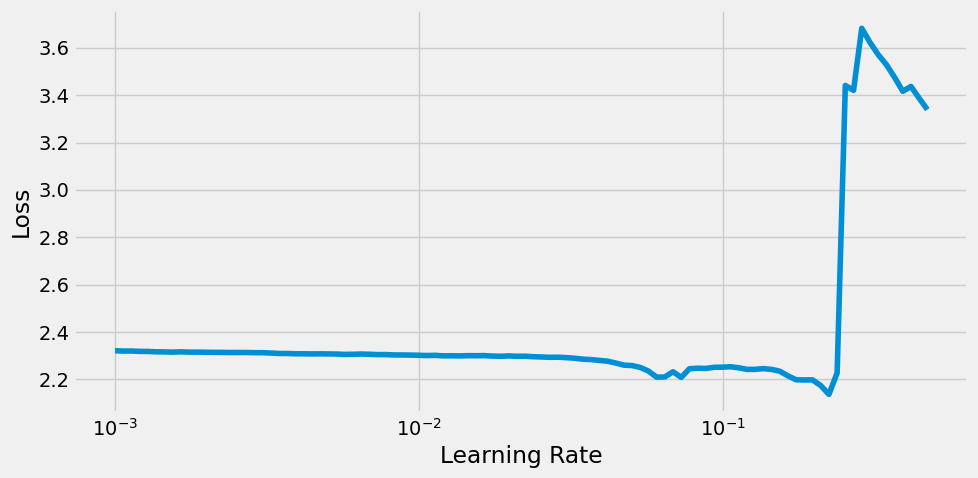

In [21]:
torch.manual_seed(42)
lenet_scheduler = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_scheduler.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_scheduler.add_module('relu1', nn.ReLU())
lenet_scheduler.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_scheduler.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_scheduler.add_module('relu2', nn.ReLU())
lenet_scheduler.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_scheduler.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_scheduler.add_module('relu3', nn.ReLU())
# Flattening
lenet_scheduler.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_scheduler.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_scheduler.add_module('relu4', nn.ReLU())
# Output Layer
lenet_scheduler.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

lr = 1e-3
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_scheduler = optim.SGD(lenet_scheduler.parameters(), lr=lr, momentum=0.9, nesterov=True)

arch_scheduler = Architecture(lenet_scheduler, multi_loss_fn, optimizer_scheduler)
arch_scheduler.set_loaders(train_loader, val_loader)

# LR Range Test
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
arch_scheduler.lr_range_test(train_loader, end_lr=0.5, num_iter=100, ax=ax)
plt.show()

### 2. ReduceLROnPlateau
Este scheduler monitora uma métrica (neste caso, a perda de validação). Se a métrica não melhorar por um determinado número de épocas (`patience`), o LR é reduzido por um fator (`factor`). Isso permite que o modelo faça ajustes finos quando a convergência estagna.

Training with ReduceLROnPlateau:


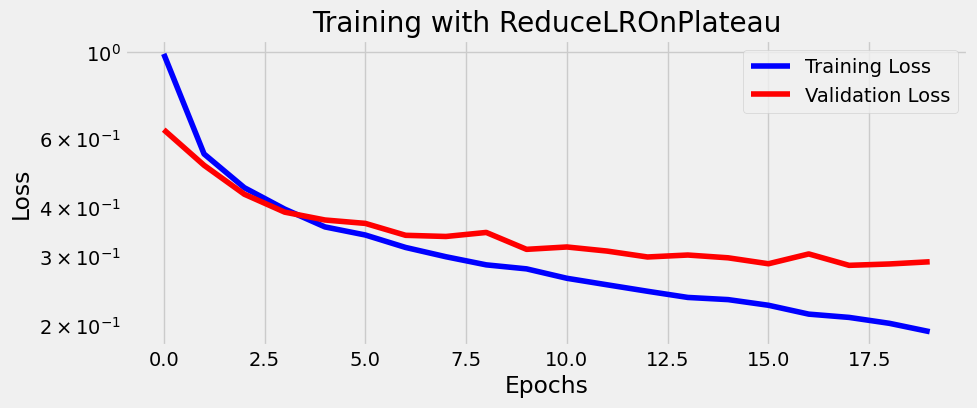

Latest Training Loss: 0.1932
Latest Validation Loss: 0.2915
Training Accuracy: 92.76%
Training Accuracy: 92.76%
Validation Accuracy: 90.13%
Validation Accuracy: 90.13%


In [27]:
torch.manual_seed(42)
lenet_scheduler = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_scheduler.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_scheduler.add_module('relu1', nn.ReLU())
lenet_scheduler.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_scheduler.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_scheduler.add_module('relu2', nn.ReLU())
lenet_scheduler.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_scheduler.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_scheduler.add_module('relu3', nn.ReLU())
# Flattening
lenet_scheduler.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_scheduler.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_scheduler.add_module('relu4', nn.ReLU())
# Output Layer
lenet_scheduler.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

# Using a higher initial LR and a scheduler
lr = 0.001
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_scheduler = optim.SGD(lenet_scheduler.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer_scheduler, mode='min', factor=0.1, patience=3)

arch_scheduler = Architecture(lenet_scheduler, multi_loss_fn, optimizer_scheduler)
arch_scheduler.set_loaders(train_loader, val_loader)
arch_scheduler.set_lr_scheduler(scheduler)

print("Training with ReduceLROnPlateau:")
arch_scheduler.train(20)

fig = arch_scheduler.plot_losses()
plt.title("Training with ReduceLROnPlateau")
plt.show()

print(f"Latest Training Loss: {arch_scheduler.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_scheduler.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_scheduler.train_loader, arch_scheduler.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_scheduler.val_loader, arch_scheduler.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

### 3. StepLR
O `StepLR` é um scheduler mais rígido que reduz a taxa de aprendizado em intervalos fixos. A cada `step_size` épocas, o LR é multiplicado por `gamma`.

Training with StepLR:


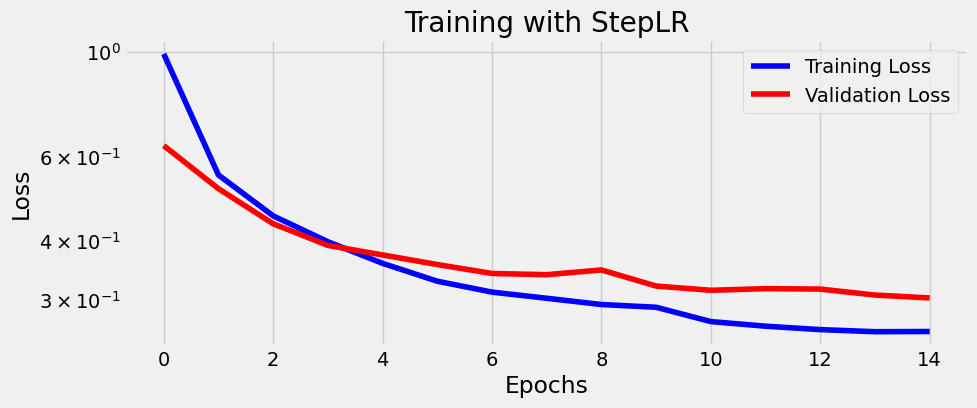

Latest Training Loss: 0.2569
Latest Validation Loss: 0.3024
Training Accuracy: 90.75%
Training Accuracy: 90.75%
Validation Accuracy: 89.31%
Validation Accuracy: 89.31%


In [28]:
# Example with StepLR
torch.manual_seed(42)
lenet_steplr = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet_steplr.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet_steplr.add_module('relu1', nn.ReLU())
lenet_steplr.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet_steplr.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet_steplr.add_module('relu2', nn.ReLU())
lenet_steplr.add_module('maxp2', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet_steplr.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet_steplr.add_module('relu3', nn.ReLU())
# Flattening
lenet_steplr.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet_steplr.add_module('fc1', nn.Linear(in_features=120, out_features=84))
lenet_steplr.add_module('relu4', nn.ReLU())
# Output Layer
lenet_steplr.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

# Using StepLR
lr = 0.001
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_steplr = optim.SGD(lenet_steplr.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler_steplr = StepLR(optimizer_steplr, step_size=5, gamma=0.5)

arch_steplr = Architecture(lenet_steplr, multi_loss_fn, optimizer_steplr)
arch_steplr.set_loaders(train_loader, val_loader)
arch_steplr.set_lr_scheduler(scheduler_steplr)

print("Training with StepLR:")
arch_steplr.train(15)

fig = arch_steplr.plot_losses()
plt.title("Training with StepLR")
plt.show()

print(f"Latest Training Loss: {arch_steplr.losses[-1]:.4f}")
print(f"Latest Validation Loss: {arch_steplr.val_losses[-1]:.4f}")

# training accuracy
train_correct_per_class = Architecture.loader_apply(arch_steplr.train_loader, arch_steplr.correct)
total_train_correct = train_correct_per_class[:, 0].sum().item()
total_train_samples = train_correct_per_class[:, 1].sum().item()
train_accuracy = (total_train_correct / total_train_samples) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")

# validation accuracy
val_correct_per_class = Architecture.loader_apply(arch_steplr.val_loader, arch_steplr.correct)
total_val_correct = val_correct_per_class[:, 0].sum().item()
total_val_samples = val_correct_per_class[:, 1].sum().item()
val_accuracy = (total_val_correct / total_val_samples) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")